In [26]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

# Define the objective function
def gomez_objective(x):
    x1, x2 = x
    return (4 - 2.1 * x1**2 + (1/3) * x1**4) * x1**2 + x1 * x2 + (-4 + 4 * x2**2) * x2**2

# Define the constraint function
def gomez_constraint(x):
    x1, x2 = x
    return -np.sin(4 * np.pi * x1) + 2 * np.sin(2 * np.pi * x2)**2

N = 100

C:\Users\justi\anaconda3\envs\uq\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


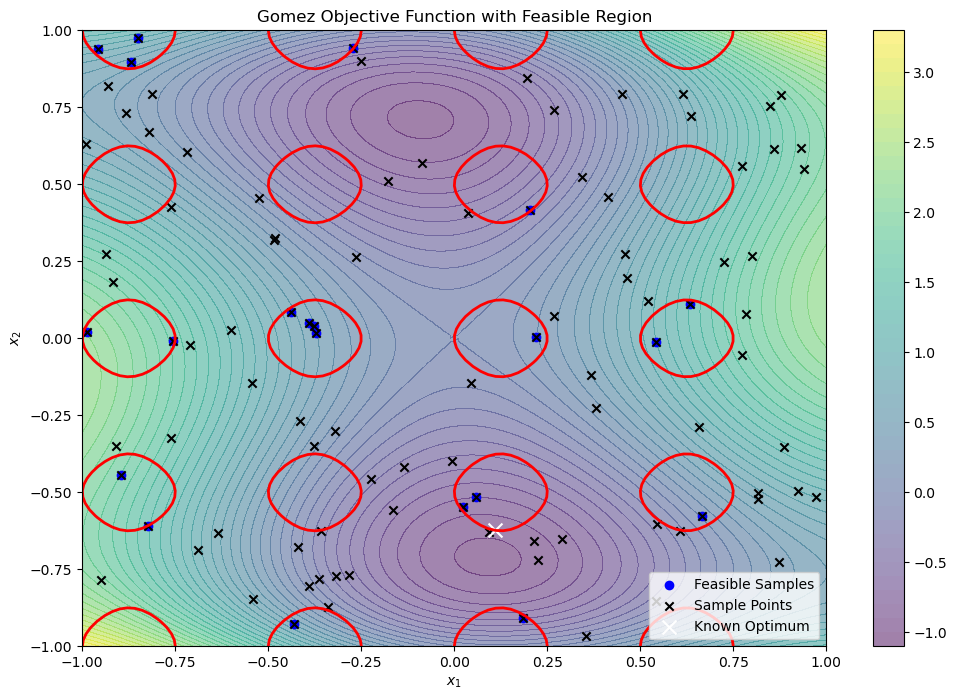

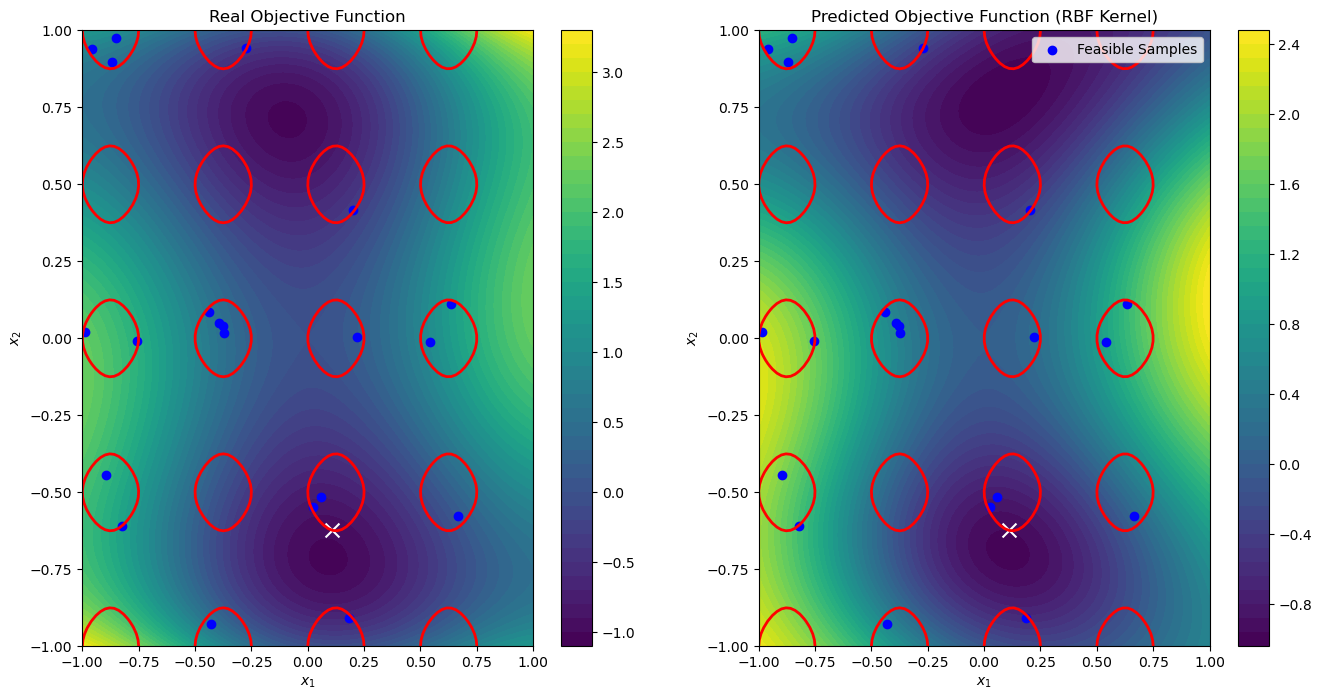

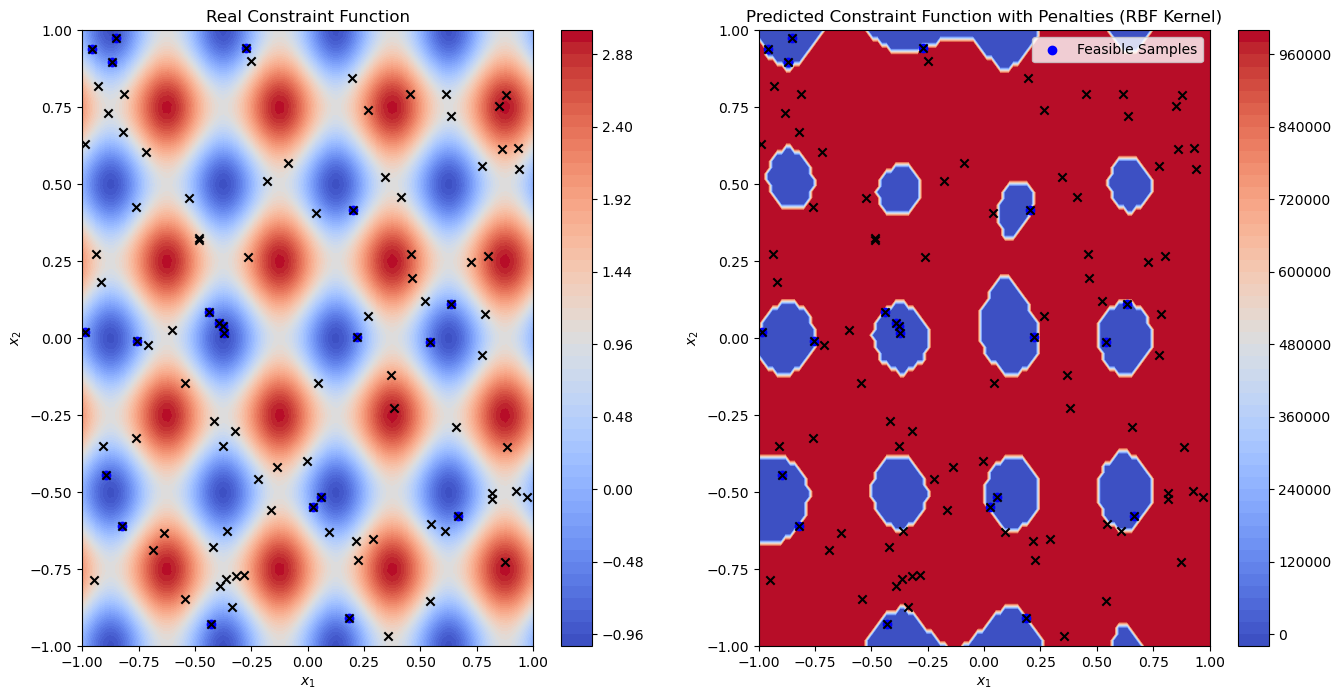

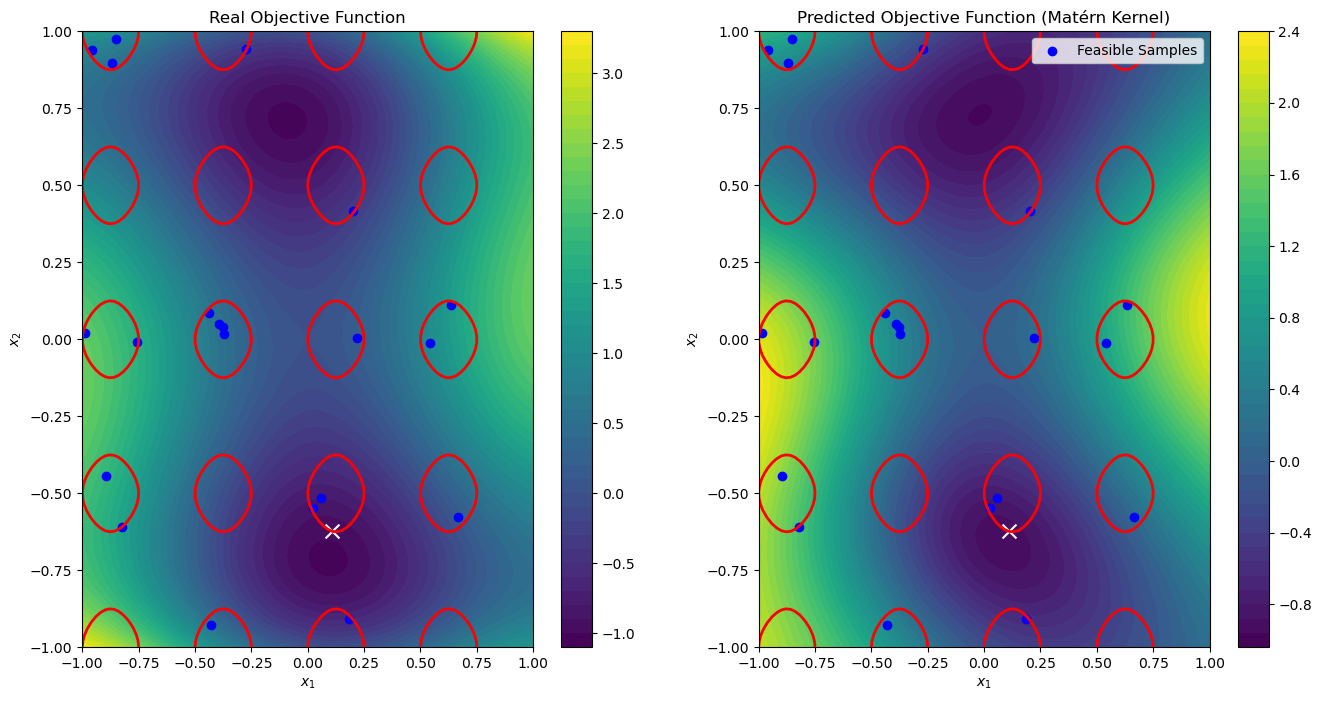

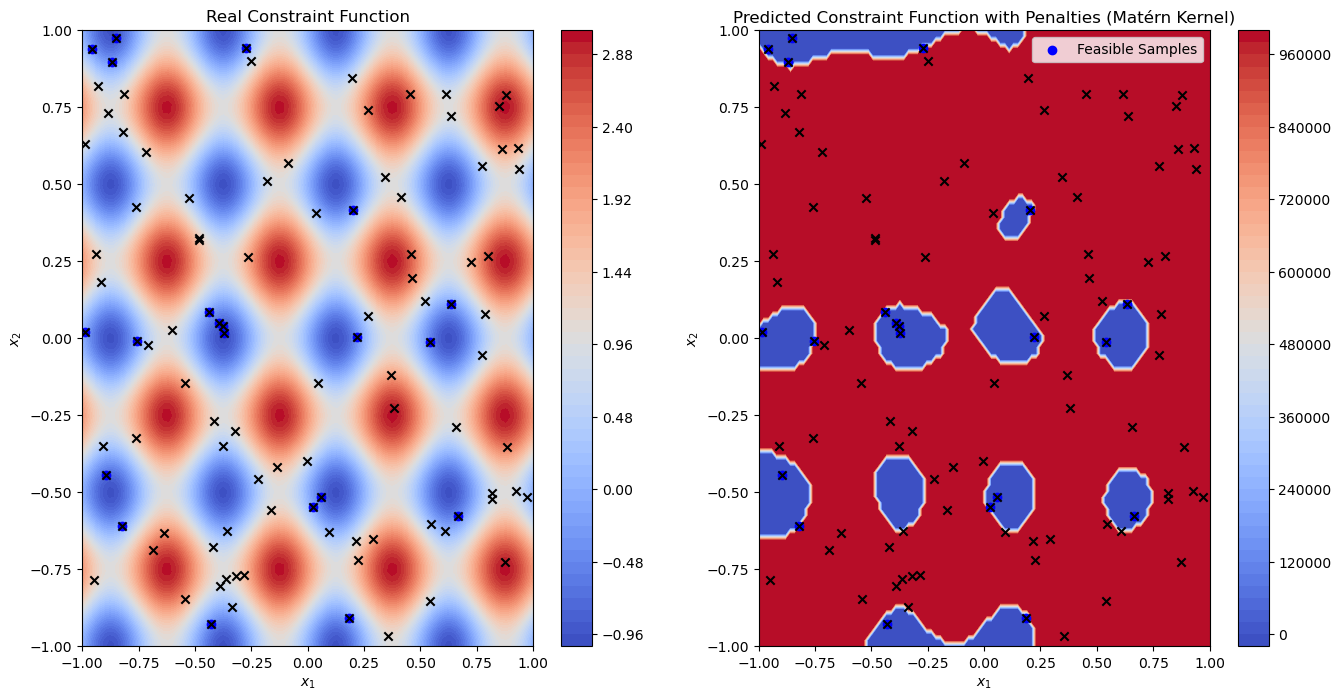

In [27]:
# Generate a grid of points
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
Z = np.zeros_like(X1)
G = np.zeros_like(X1)

# Compute the objective and constraint values
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        Z[i, j] = gomez_objective([X1[i, j], X2[i, j]])
        G[i, j] = gomez_constraint([X1[i, j], X2[i, j]])

# Apply penalty to infeasible regions
G_penalized = np.where(G > 0, 1e6, G)

# Sample points for training the GP (both feasible and infeasible)
np.random.seed(42)
sample_points = np.random.uniform(-1, 1, (N, 2))
sample_values = np.array([gomez_objective(x) for x in sample_points])
constraint_values = np.array([gomez_constraint(x) for x in sample_points])

# Filter out infeasible points (unobservable regions)
feasible_points = sample_points[constraint_values <= 0]
feasible_values = sample_values[constraint_values <= 0]

# Define the kernels
rbf_kernel = C(1.0, (1e-3, 1e3)) * RBF([1.0, 1.0], (1e-3, 1e3))
matern_kernel = C(1.0, (1e-3, 1e3)) * Matern([1.0, 1.0], nu=2.5)

# Fit the GP models using feasible points only for the objective
gp_rbf = GaussianProcessRegressor(kernel=rbf_kernel, n_restarts_optimizer=10)
gp_matern = GaussianProcessRegressor(kernel=matern_kernel, n_restarts_optimizer=10)

gp_rbf.fit(feasible_points, feasible_values)
gp_matern.fit(feasible_points, feasible_values)

# Fit the GP models for the constraints
gp_constraint_rbf = GaussianProcessRegressor(kernel=rbf_kernel, n_restarts_optimizer=10)
gp_constraint_matern = GaussianProcessRegressor(kernel=matern_kernel, n_restarts_optimizer=10)

gp_constraint_rbf.fit(sample_points, constraint_values)
gp_constraint_matern.fit(sample_points, constraint_values)

# Predict over the grid
Z_pred_rbf, _ = gp_rbf.predict(np.c_[X1.ravel(), X2.ravel()], return_std=True)
Z_pred_rbf = Z_pred_rbf.reshape(X1.shape)

Z_pred_matern, _ = gp_matern.predict(np.c_[X1.ravel(), X2.ravel()], return_std=True)
Z_pred_matern = Z_pred_matern.reshape(X1.shape)

# Predict constraints over the grid
G_pred_rbf, _ = gp_constraint_rbf.predict(np.c_[X1.ravel(), X2.ravel()], return_std=True)
G_pred_rbf = G_pred_rbf.reshape(X1.shape)
G_penalized_pred_rbf = np.where(G_pred_rbf > 0, 1e6, G_pred_rbf)

G_pred_matern, _ = gp_constraint_matern.predict(np.c_[X1.ravel(), X2.ravel()], return_std=True)
G_pred_matern = G_pred_matern.reshape(X1.shape)
G_penalized_pred_matern = np.where(G_pred_matern > 0, 1e6, G_pred_matern)

# Plot 1: The objective function with feasible region
plt.figure(figsize=(12, 8))
contour = plt.contourf(X1, X2, Z, levels=50, cmap='viridis', alpha=0.5)
plt.colorbar(contour)
plt.contour(X1, X2, G, levels=[0], colors='red', linewidths=2)
plt.title('Gomez Objective Function with Feasible Region')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(feasible_points[:, 0], feasible_points[:, 1], color='blue', label='Feasible Samples')
plt.scatter(sample_points[:, 0], sample_points[:, 1], color='black', marker='x', label='Sample Points')
plt.scatter([0.1093], [-0.6234], color='white', marker='x', s=100, label='Known Optimum')
plt.legend()
plt.show()

# Plot 2: Real vs Predicted Objective Function (RBF kernel)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
contour1 = ax1.contourf(X1, X2, Z, levels=50, cmap='viridis')
ax1.contour(X1, X2, G, levels=[0], colors='red', linewidths=2)
ax1.set_title('Real Objective Function')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.scatter(feasible_points[:, 0], feasible_points[:, 1], color='blue', label='Feasible Samples')
ax1.scatter([0.1093], [-0.6234], color='white', marker='x', s=100)

contour2 = ax2.contourf(X1, X2, Z_pred_rbf, levels=50, cmap='viridis')
ax2.contour(X1, X2, G, levels=[0], colors='red', linewidths=2)
ax2.set_title('Predicted Objective Function (RBF Kernel)')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.scatter(feasible_points[:, 0], feasible_points[:, 1], color='blue', label='Feasible Samples')
ax2.scatter([0.1093], [-0.6234], color='white', marker='x', s=100)

fig.colorbar(contour1, ax=ax1)
fig.colorbar(contour2, ax=ax2)

plt.legend()
plt.show()

# Plot 3: Real vs Predicted Constraint Function with Penalties (RBF kernel)
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 8))
contour3 = ax3.contourf(X1, X2, G, levels=50, cmap='coolwarm')
ax3.set_title('Real Constraint Function')
ax3.set_xlabel('$x_1$')
ax3.set_ylabel('$x_2$')
ax3.scatter(feasible_points[:, 0], feasible_points[:, 1], color='blue', label='Feasible Samples')
ax3.scatter(sample_points[:, 0], sample_points[:, 1], color='black', marker='x')

contour4 = ax4.contourf(X1, X2, G_penalized_pred_rbf, levels=50, cmap='coolwarm')
ax4.set_title('Predicted Constraint Function with Penalties (RBF Kernel)')
ax4.set_xlabel('$x_1$')
ax4.set_ylabel('$x_2$')
ax4.scatter(feasible_points[:, 0], feasible_points[:, 1], color='blue', label='Feasible Samples')
ax4.scatter(sample_points[:, 0], sample_points[:, 1], color='black', marker='x')

fig.colorbar(contour3, ax=ax3)
fig.colorbar(contour4, ax=ax4)

plt.legend()
plt.show()

# Plot 4: Real vs Predicted Objective Function (Matérn kernel)
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(16, 8))
contour5 = ax5.contourf(X1, X2, Z, levels=50, cmap='viridis')
ax5.contour(X1, X2, G, levels=[0], colors='red', linewidths=2)
ax5.set_title('Real Objective Function')
ax5.set_xlabel('$x_1$')
ax5.set_ylabel('$x_2$')
ax5.scatter(feasible_points[:, 0], feasible_points[:, 1], color='blue', label='Feasible Samples')
ax5.scatter([0.1093], [-0.6234], color='white', marker='x', s=100)

contour6 = ax6.contourf(X1, X2, Z_pred_matern, levels=50, cmap='viridis')
ax6.contour(X1, X2, G, levels=[0], colors='red', linewidths=2)
ax6.set_title('Predicted Objective Function (Matérn Kernel)')
ax6.set_xlabel('$x_1$')
ax6.set_ylabel('$x_2$')
ax6.scatter(feasible_points[:, 0], feasible_points[:, 1], color='blue', label='Feasible Samples')
ax6.scatter([0.1093], [-0.6234], color='white', marker='x', s=100)

fig.colorbar(contour5, ax=ax5)
fig.colorbar(contour6, ax=ax6)

plt.legend()
plt.show()

# Plot 5: Real vs Predicted Constraint Function with Penalties (Matérn kernel)
fig, (ax7, ax8) = plt.subplots(1, 2, figsize=(16, 8))
contour7 = ax7.contourf(X1, X2, G, levels=50, cmap='coolwarm')
ax7.set_title('Real Constraint Function')
ax7.set_xlabel('$x_1$')
ax7.set_ylabel('$x_2$')
ax7.scatter(feasible_points[:, 0], feasible_points[:, 1], color='blue', label='Feasible Samples')
ax7.scatter(sample_points[:, 0], sample_points[:, 1], color='black', marker='x')

contour8 = ax8.contourf(X1, X2, G_penalized_pred_matern, levels=50, cmap='coolwarm')
ax8.set_title('Predicted Constraint Function with Penalties (Matérn Kernel)')
ax8.set_xlabel('$x_1$')
ax8.set_ylabel('$x_2$')
ax8.scatter(feasible_points[:, 0], feasible_points[:, 1], color='blue', label='Feasible Samples')
ax8.scatter(sample_points[:, 0], sample_points[:, 1], color='black', marker='x')

fig.colorbar(contour7, ax=ax7)
fig.colorbar(contour8, ax=ax8)

plt.legend()
plt.show()


C:\Users\justi\anaconda3\envs\uq\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\justi\anaconda3\envs\uq\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\justi\anaconda3\envs\uq\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


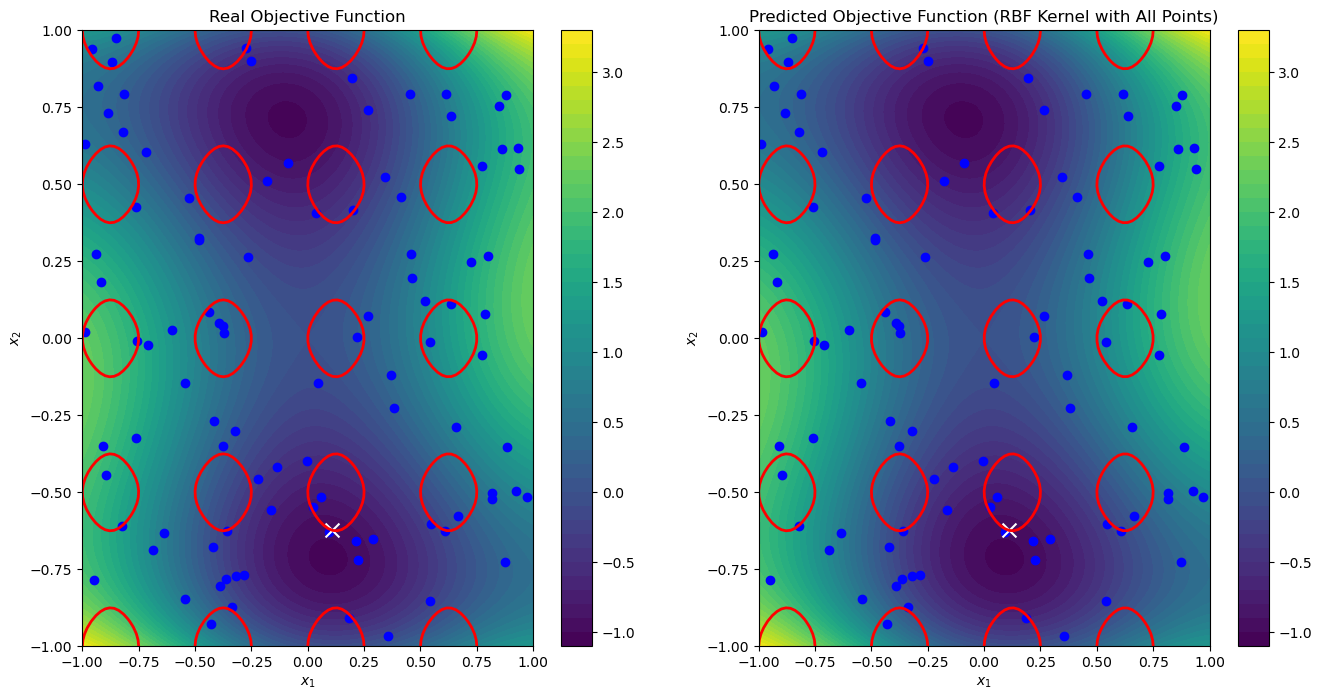

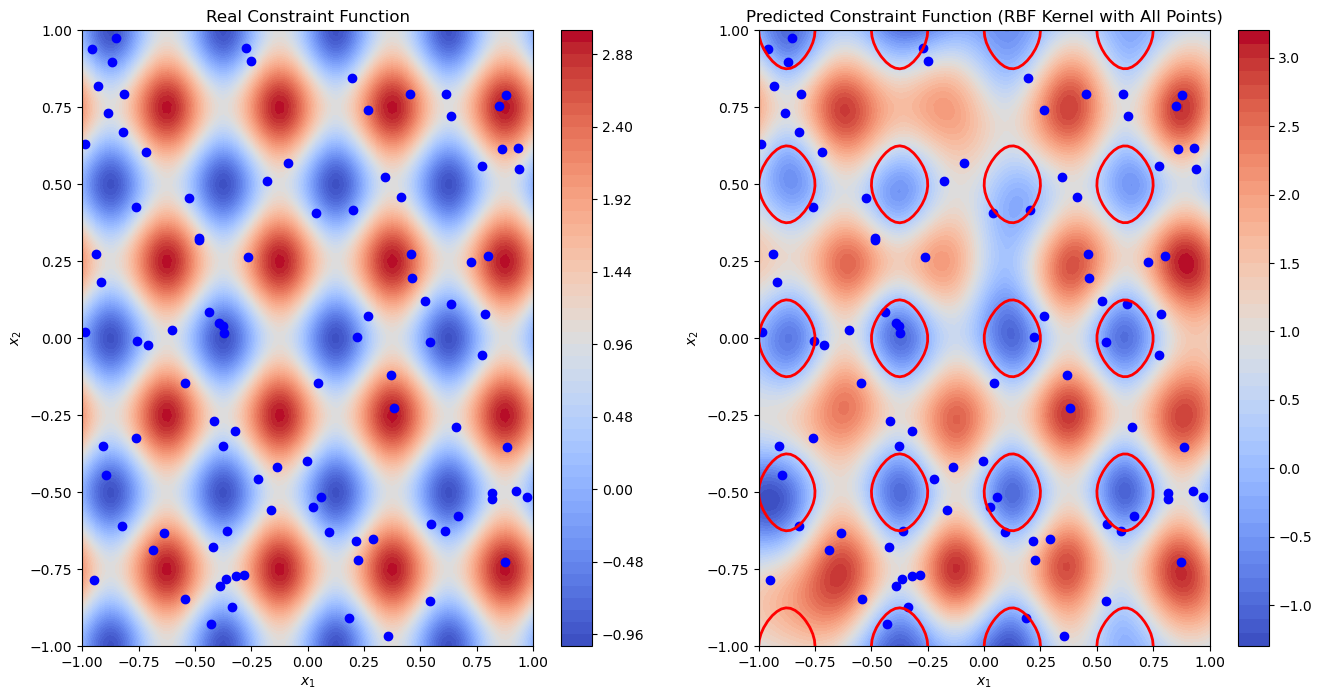

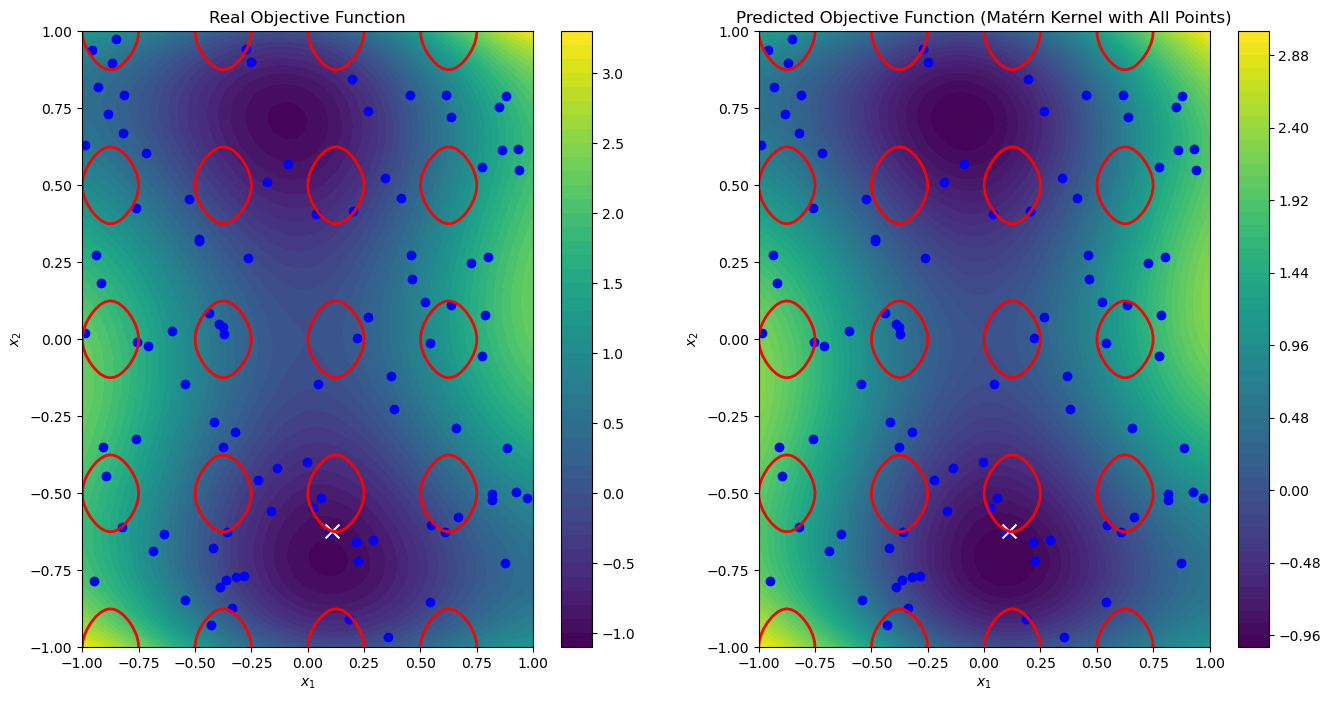

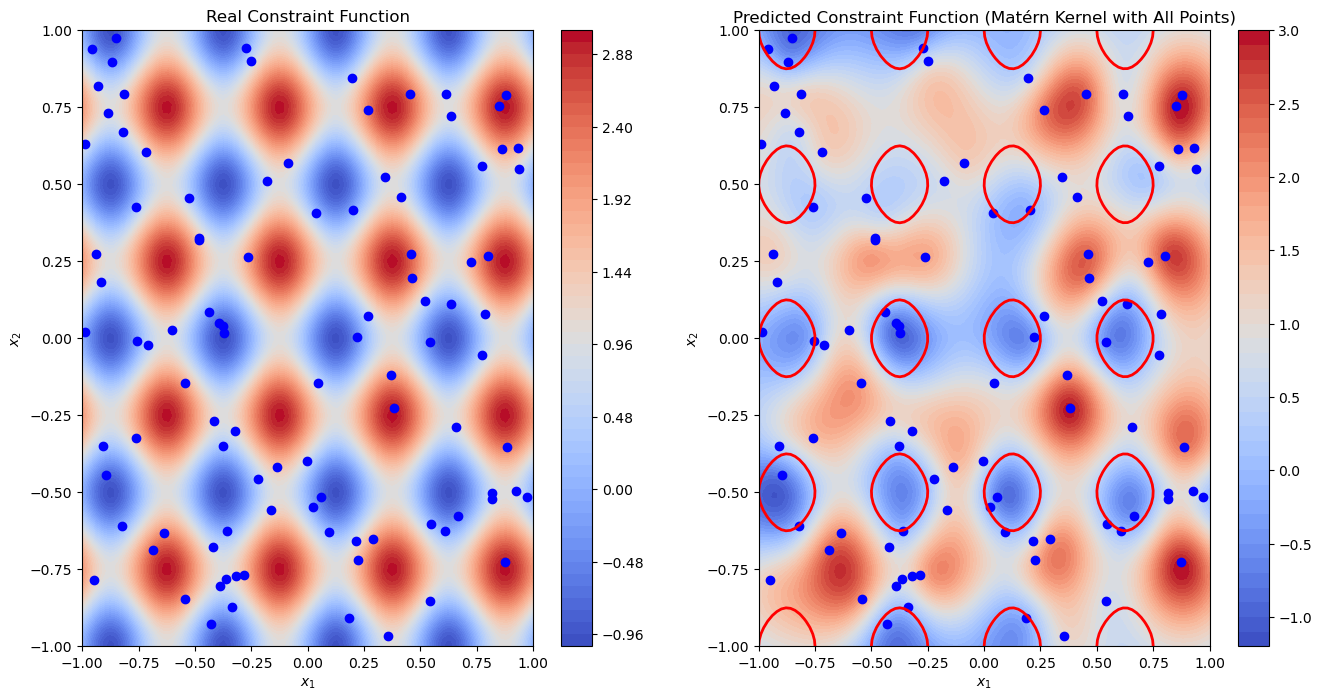

In [29]:
# Sample 100 points for training the GP (both feasible and infeasible)
np.random.seed(42)
sample_points = np.random.uniform(-1, 1, (N, 2))
sample_values = np.array([gomez_objective(x) for x in sample_points])
constraint_values = np.array([gomez_constraint(x) for x in sample_points])

# Fit the GP models using all points for the objective
gp_rbf_all = GaussianProcessRegressor(kernel=rbf_kernel, n_restarts_optimizer=10)
gp_matern_all = GaussianProcessRegressor(kernel=matern_kernel, n_restarts_optimizer=10)

gp_rbf_all.fit(sample_points, sample_values)
gp_matern_all.fit(sample_points, sample_values)

# Fit the GP models for the constraints using all points
gp_constraint_rbf_all = GaussianProcessRegressor(kernel=rbf_kernel, n_restarts_optimizer=10)
gp_constraint_matern_all = GaussianProcessRegressor(kernel=matern_kernel, n_restarts_optimizer=10)

gp_constraint_rbf_all.fit(sample_points, constraint_values)
gp_constraint_matern_all.fit(sample_points, constraint_values)

# Predict over the grid
Z_pred_rbf_all, _ = gp_rbf_all.predict(np.c_[X1.ravel(), X2.ravel()], return_std=True)
Z_pred_rbf_all = Z_pred_rbf_all.reshape(X1.shape)

Z_pred_matern_all, _ = gp_matern_all.predict(np.c_[X1.ravel(), X2.ravel()], return_std=True)
Z_pred_matern_all = Z_pred_matern_all.reshape(X1.shape)

# Predict constraints over the grid
G_pred_rbf_all, _ = gp_constraint_rbf_all.predict(np.c_[X1.ravel(), X2.ravel()], return_std=True)
G_pred_rbf_all = G_pred_rbf_all.reshape(X1.shape)

G_pred_matern_all, _ = gp_constraint_matern_all.predict(np.c_[X1.ravel(), X2.ravel()], return_std=True)
G_pred_matern_all = G_pred_matern_all.reshape(X1.shape)

# Plot Real vs Predicted Objective Function (RBF kernel) with all points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
contour1 = ax1.contourf(X1, X2, Z, levels=50, cmap='viridis')
ax1.contour(X1, X2, G, levels=[0], colors='red', linewidths=2)
ax1.set_title('Real Objective Function')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.scatter(sample_points[:, 0], sample_points[:, 1], color='blue')
ax1.scatter([0.1093], [-0.6234], color='white', marker='x', s=100)

contour2 = ax2.contourf(X1, X2, Z_pred_rbf_all, levels=50, cmap='viridis')
ax2.contour(X1, X2, G, levels=[0], colors='red', linewidths=2)
ax2.set_title('Predicted Objective Function (RBF Kernel with All Points)')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.scatter(sample_points[:, 0], sample_points[:, 1], color='blue')
ax2.scatter([0.1093], [-0.6234], color='white', marker='x', s=100)

fig.colorbar(contour1, ax=ax1)
fig.colorbar(contour2, ax=ax2)
plt.show()

# Plot Real vs Predicted Constraint Function (RBF kernel) with all points
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 8))
contour3 = ax3.contourf(X1, X2, G, levels=50, cmap='coolwarm')
ax3.set_title('Real Constraint Function')
ax3.set_xlabel('$x_1$')
ax3.set_ylabel('$x_2$')
ax3.scatter(sample_points[:, 0], sample_points[:, 1], color='blue')

contour4 = ax4.contourf(X1, X2, G_pred_rbf_all, levels=50, cmap='coolwarm')
ax4.contour(X1, X2, G, levels=[0], colors='red', linewidths=2)
ax4.set_title('Predicted Constraint Function (RBF Kernel with All Points)')
ax4.set_xlabel('$x_1$')
ax4.set_ylabel('$x_2$')
ax4.scatter(sample_points[:, 0], sample_points[:, 1], color='blue')

fig.colorbar(contour3, ax=ax3)
fig.colorbar(contour4, ax=ax4)
plt.show()

# Plot Real vs Predicted Objective Function (Matérn kernel) with all points
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(16, 8))
contour5 = ax5.contourf(X1, X2, Z, levels=50, cmap='viridis')
ax5.contour(X1, X2, G, levels=[0], colors='red', linewidths=2)
ax5.set_title('Real Objective Function')
ax5.set_xlabel('$x_1$')
ax5.set_ylabel('$x_2$')
ax5.scatter(sample_points[:, 0], sample_points[:, 1], color='blue')
ax5.scatter([0.1093], [-0.6234], color='white', marker='x', s=100)

contour6 = ax6.contourf(X1, X2, Z_pred_matern_all, levels=50, cmap='viridis')
ax6.contour(X1, X2, G, levels=[0], colors='red', linewidths=2)
ax6.set_title('Predicted Objective Function (Matérn Kernel with All Points)')
ax6.set_xlabel('$x_1$')
ax6.set_ylabel('$x_2$')
ax6.scatter(sample_points[:, 0], sample_points[:, 1], color='blue')
ax6.scatter([0.1093], [-0.6234], color='white', marker='x', s=100)

fig.colorbar(contour5, ax=ax5)
fig.colorbar(contour6, ax=ax6)
plt.show()

# Plot Real vs Predicted Constraint Function (Matérn kernel) with all points
fig, (ax7, ax8) = plt.subplots(1, 2, figsize=(16, 8))
contour7 = ax7.contourf(X1, X2, G, levels=50, cmap='coolwarm')
ax7.set_title('Real Constraint Function')
ax7.set_xlabel('$x_1$')
ax7.set_ylabel('$x_2$')
ax7.scatter(sample_points[:, 0], sample_points[:, 1], color='blue')

contour8 = ax8.contourf(X1, X2, G_pred_matern_all, levels=50, cmap='coolwarm')
ax8.contour(X1, X2, G, levels=[0], colors='red', linewidths=2)
ax8.set_title('Predicted Constraint Function (Matérn Kernel with All Points)')
ax8.set_xlabel('$x_1$')
ax8.set_ylabel('$x_2$')
ax8.scatter(sample_points[:, 0], sample_points[:, 1], color='blue')

fig.colorbar(contour7, ax=ax7)
fig.colorbar(contour8, ax=ax8)
plt.show()
